# Demo: Visual odometry using single image sequence

Course: NICF- Spatial Reasoning from Sensor Data (SF)

Website: https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor-data/artificial-intelligence

Contact: Dr. Tian Jing

Email: tianjing@nus.edu.sg

## Objective

- Perform visual odometry using single image sequence

## Installation guideline
- Open `Anaconda Prompt`

- Append the channel `conda-forge` into your conda configuration.

`conda config --append channels conda-forge`

- Create a new virtual environment `srsdv` or install additional packages in your own environment

**[Windows, CPU version]**

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow=1.12.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras=2.2.4 pillow=5.4.1 notebook=5.7.4 pandas=0.24.2 h5py=2.8.0`

**[Windows, GPU version, CUDA 9.0]**

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow-gpu=1.12.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras-gpu=2.2.4 pillow=5.4.1 notebook=5.7.4 pandas=0.24.2 h5py=2.8.0`

- Activate the environment `srsdv`

`conda activate srsdv`

- Browse to the folder that contains the workshop files, then run Jupyter Notebook

`jupyter notebook`

## Reference
- Reference code: https://github.com/avisingh599/mono-vo
- KITTI dataset, link: http://www.cvlibs.net/datasets/kitti/eval_odometry.php  
    - "Download odometry data set (grayscale, 22 GB)"
    - "Download odometry ground truth poses (4 MB)".


In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math


In [2]:

class CameraParameters():
    def __init__(self, fx, fy, cx, cy):
        self.fx = fx
        self.fy = fy
        self.cx = cx
        self.cy = cy

    @property
    def camera_matrix(self):
        matrix = np.array([[self.fx, 0.0, self.cx],
                           [0.0, self.fx, self.cy],
                           [0.0, 0.0, 1.0]])
        return matrix

    def __call__(self):
        return self.camera_matrix


class Dataset():
    def __init__(self):
        pass

    def image_path_left(self, index):
        temp_path = self.image_format_left.format(index)
        return (self.path + '/' + temp_path)

    def count_image(self):
        extension = os.path.splitext(self.image_format_left)[-1]
        wildcard = os.path.join(self.path, '*' + extension)
        self.image_count = len(glob.glob(wildcard))

    def load_ground_truth_pose(self, gt_path):
        ground_truth = None
        if not os.path.exists(gt_path):
            print("ground truth path is not found.", gt_path)
            return None

        ground_truth = []

        with open(gt_path) as gt_file:
            gt_lines = gt_file.readlines()

            for gt_line in gt_lines:
                pose = self.convert_text_to_ground_truth(gt_line)
                ground_truth.append(pose)
        return ground_truth

    def convert_text_to_ground_truth(self, gt_line):
        pass

                
class KittiDataset(Dataset):
    def __init__(self, path):
        self.image_format_left = '{:06d}.png'
        self.path = os.path.join(path, 'image_0')
        self.calibfile = os.path.join(path, 'calib.txt')
        sequence_count = os.path.dirname(self.path).split('/')[-1]

        gt_path = os.path.join(path, sequence_count + '.txt')

        self.count_image()
        self.ground_truth = self.load_ground_truth_pose(gt_path)
        self.camera_matrix = self.load_camera_parameters(self.calibfile)

    def convert_text_to_ground_truth(self, gt_line):
        matrix = np.array(gt_line.split()).reshape((3, 4)).astype(np.float32)
        return matrix

    def load_camera_parameters(self, calibfile):
        if not os.path.exists(calibfile):
            print("camera parameter file path is not found.", calibfile)
            return None

        with open(calibfile, 'r') as f:
            line = f.readline()
            part = line.split()
            param = CameraParameters(float(part[1]), float(part[6]),
                                     float(part[3]), float(part[7]))

            return param


dataset_dict = {'kitti': KittiDataset}


def create_dataset(options):
    return dataset_dict[options.dataset](options.path)

def calc_euclid_dist(p1, p2):
    a = math.pow((p1[0] - p2[0]), 2.0) + math.pow((p1[1] - p2[1]), 2.0)
    return math.sqrt(a)


In [3]:
class options:
    dataset = 'kitti'
    path = 'data/00/'
    
dataset = create_dataset(options)

In [4]:
feature_detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)

lk_params = dict(winSize=(21, 21), criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.03))

current_pos = np.zeros((3, 1))
current_rot = np.eye(3)

print("There are %d images in the dataset." % (dataset.image_count))

prev_image = None

valid_ground_truth = False
if dataset.ground_truth is not None:
    valid_ground_truth = True

if dataset.camera_matrix is not None:
    camera_matrix = dataset.camera_matrix()
else:
    camera_matrix = np.array([[718.8560, 0.0, 607.1928],
                              [0.0, 718.8560, 185.2157],
                              [0.0, 0.0, 1.0]])
    

There are 1001 images in the dataset.


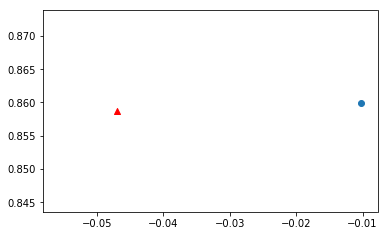

In [5]:

position_figure = plt.figure()
position_axes = position_figure.add_subplot(1, 1, 1)
frame_index_list = []
position_axes.set_aspect('equal', adjustable='box')


for index in range(dataset.image_count):
    # load image
    if not os.path.exists(dataset.image_path_left(index)):
        continue
        
    image = cv2.imread(dataset.image_path_left(index))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # main process
    keypoint = feature_detector.detect(image, None)

    if prev_image is None:
        prev_image = image
        prev_keypoint = keypoint
        continue

    points = np.array(list(map(lambda x: [x.pt], prev_keypoint)),dtype=np.float32)

    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_image,image, points, None, **lk_params)

    E, mask = cv2.findEssentialMat(p1, points, camera_matrix, cv2.RANSAC, 0.999, 1.0, None)

    points, R, t, mask = cv2.recoverPose(E, p1, points, camera_matrix)

    scale = 1.0

    # calc scale from ground truth if exists.
    if valid_ground_truth:
        ground_truth = dataset.ground_truth[index]
        ground_truth_pos = [ground_truth[0, 3], ground_truth[2, 3]]
        previous_ground_truth = dataset.ground_truth[index - 1]
        previous_ground_truth_pos = [
            previous_ground_truth[0, 3],
            previous_ground_truth[2, 3]]

        scale = calc_euclid_dist(ground_truth_pos,
                                 previous_ground_truth_pos)

    current_pos += current_rot.dot(t) * scale
    current_rot = R.dot(current_rot)

    # get ground truth if eist.
    if valid_ground_truth:
        ground_truth = dataset.ground_truth[index]
        position_axes.scatter(ground_truth[0, 3], ground_truth[2, 3], marker='^', c='r')

    # calc rotation error with ground truth.
    if valid_ground_truth:
        ground_truth = dataset.ground_truth[index]
        ground_truth_rotation = ground_truth[0: 3, 0: 3]
        r_vec, _ = cv2.Rodrigues(current_rot.dot(ground_truth_rotation.T))
        #rotation_error = np.linalg.norm(r_vec)
        frame_index_list.append(index)
        #rotation_error_list.append(rotation_error)

    position_axes.scatter(current_pos[0][0], current_pos[2][0])
    plt.pause(.01)

    img = cv2.drawKeypoints(image, keypoint, None)
    cv2.putText(img, dataset.image_path_left(index), (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    cv2.imshow('Input frames with features (Press ESC to exit). Results are saved as position_plot.png', img)
    if cv2.waitKey(1) == 27:
        break

    prev_image = image
    prev_keypoint = keypoint

cv2.destroyAllWindows()
position_figure.savefig("position_plot.png")


**Have a nice day!**